В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [86]:
!pip install xgboost
!pip install hyperopt
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 2.7 MB/s eta 0:00:00a 0:00:010m


In [87]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from hyperopt import STATUS_OK, fmin, tpe, hp, Trials
import lightgbm as lgb

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [6]:
raw_df = pd.read_csv('data/bank-customer-churn-prediction-dlu/train.csv', index_col='id')
raw_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [3]:
train_df, test_df = split_train_val(raw_df, 'Exited')

In [13]:
columns = raw_df.drop('CustomerId', axis=1).drop('Exited', axis=1).drop('Surname', axis=1).columns.to_list()
columns

['CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [16]:
train_inputs, train_target = separate_inputs_targets(train_df, columns, 'Exited')

In [18]:
test_inputs, test_target = separate_inputs_targets(test_df, columns, 'Exited')

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [20]:
categorical_columns = test_inputs.select_dtypes("object")
for cat in categorical_columns:
    train_inputs[cat] = pd.Categorical(train_inputs[cat])
    test_inputs[cat] = pd.Categorical(test_inputs[cat])

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [28]:
xgb_clf = XGBClassifier(
    max_depth=7,
    n_estimators = 15,
    enable_categorical=True,
    use_label_encoder=False,
    missing = np.nan,
    random_state = 12
)

In [29]:
xgb_clf.fit(train_inputs, train_target)

[23:08:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=15, n_jobs=None,
              num_parallel_tree=None, random_state=12, ...)

In [31]:
train_target_pred = xgb_clf.predict(train_inputs)
auc_score_train = roc_auc_score(train_target, train_target_pred)
test_target_pred = xgb_clf.predict(test_inputs)
auc_score_test = roc_auc_score(test_target, test_target_pred)
print("Train score {}, test score {}".format(auc_score_train, auc_score_test))

Train score 0.8626250801392045, test score 0.8150764798683038


На мою думку результати покразилися

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [98]:
def objective(params):
    print(params)
    if params['light']!=1 :
        clf = XGBClassifier(
            n_estimators = int(params['n_estimators']),
            max_depth = int(params['max_depth']),
            eta = params['eta'],
            min_child_weight = params['min_child_weight'],
            #max_leaf_nodes = int(params['max_leaf_nodes']),
            gamma = params['gamma'],
            alpha = params['alpha'],
            enable_categorical=True,
            missing = np.nan,
            early_stopping_rounds=10
        )
    else :
        cat_feature_indexes = [train_inputs.columns.get_loc(col) for col in categorical_columns]
        clf = lgb.LGBMClassifier(
            n_estimators = int(params['n_estimators']),
            max_depth = int(params['max_depth']),
            num_leaves = int(params['num_leaves']),
            min_child_weight = params['min_child_weight'],
            #max_leaf_nodes = int(params['max_leaf_nodes']),
            lambda_l1 = params['lambda_l1'],
            lambda_l2 = params['lambda_l2'],
            feature_fraction = params['feature_fraction'],
            cat_feature=cat_feature_indexes,
            missing = np.nan,
            early_stopping_rounds=10
        )
    clf.fit(train_inputs, train_target, eval_set=[(train_inputs, train_target), (test_inputs, test_target)])
    predicted_test = clf.predict(test_inputs)
    score = roc_auc_score(test_target, predicted_test)
    return {'loss' : -score, 'status': STATUS_OK}

In [79]:
space = {
    'n_estimators' : hp.quniform('n_estimators', 50, 500, 25),
    'max_depth' : hp.choice('max_depth', np.arange(2, 15, dtype=int)),
    'eta' : hp.uniform('eta', 0, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    #'max_leaf_nodes' : hp.quniform('max_leaf_nodes', 3, 50, 2),
    'gamma' : hp.quniform('gamma', 0, 10, 1),
    'alpha' : hp.quniform('alpha', 0, 10, 1),
}
trials = Trials()
best = fmin(fn=objective, space=space, max_evals=20, trials = trials, algo=tpe.suggest)

100%|██████████| 20/20 [00:01<00:00, 18.22trial/s, best loss: -0.8271795047671309]


In [81]:
best

{'alpha': 1.0,
 'eta': 0.18209768318561037,
 'gamma': 3.0,
 'max_depth': 8,
 'min_child_weight': 7.0,
 'n_estimators': 100.0}

In [84]:
clf_tuned = XGBClassifier(
        n_estimators = int(best['n_estimators']),
        max_depth = int(best['max_depth']),
        eta = best['eta'],
        min_child_weight = best['min_child_weight'],
        #max_leaf_nodes = int(params['max_leaf_nodes']),
        gamma = best['gamma'],
        alpha = best['alpha'],
        enable_categorical=True,
        missing = np.nan,
        early_stopping_rounds=10
    )
clf_tuned.fit(train_inputs, train_target, eval_set=[(test_inputs, test_target)], verbose = False)
clf_tuned_predictions_train = clf_tuned.predict(train_inputs)
clf_tuned_predictions_test = clf_tuned.predict(test_inputs)
score_train_xgb_tuned = roc_auc_score(train_target, clf_tuned_predictions_train)
score_test_xgb_tuned = roc_auc_score(test_target, clf_tuned_predictions_test)

In [85]:
print("Tuned xgboost score train {}, test {}".format(score_train_xgb_tuned, score_test_xgb_tuned))

Tuned xgboost score train 0.8408180908180908, test 0.8255401605048357


Модель покращилась на тестовій вибірці

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [99]:
lightspace = {
    'n_estimators' : hp.quniform('n_estimators', 50, 500, 25),
    'max_depth' : hp.choice('max_depth', np.arange(2, 15, dtype=int)),
    'num_leaves' : hp.choice('num_leaves', np.arange(2, 50, dtype=int)),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'lambda_l1' : hp.uniform('lambda_l1', 0, 1),
    'lambda_l2' : hp.uniform('lambda_l2', 0, 1),
    'feature_fraction' : hp.uniform('feature_fraction', 0, 1),
    'light': 1
}
trials_l = Trials()
best_l = fmin(fn=objective, space=lightspace, max_evals=20, trials = trials_l, algo=tpe.suggest)

{'feature_fraction': 0.04859754236109304, 'lambda_l1': 0.3202081220055012, 'lambda_l2': 0.01748524119217154, 'light': 1, 'max_depth': 13, 'min_child_weight': 6.0, 'n_estimators': 75.0, 'num_leaves': 41}
[LightGBM] [Warning] Unknown parameter: missing       
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] lambda_l1 is set=0.3202081220055012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3202081220055012
[LightGBM] [Warning] feature_fraction is set=0.04859754236109304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.04859754236109304
[LightGBM] [Warning] lambda_l2 is set=0.01748524119217154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01748524119217154
[LightGBM] [Warning] Unknown parameter: missing       
[LightGBM] [Warning] categorical_feature is set with cat_feature=1,2, categorical_column=1,2 will be ignored. Current value: cat

In [100]:
best_l

{'feature_fraction': 0.788739438286917,
 'lambda_l1': 0.934122038598395,
 'lambda_l2': 0.5661089565746366,
 'max_depth': 8,
 'min_child_weight': 6.0,
 'n_estimators': 175.0,
 'num_leaves': 13}

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [103]:
cat_feature_indexes = [train_inputs.columns.get_loc(col) for col in categorical_columns]
light_tuned = lgb.LGBMClassifier(
    n_estimators = int(best_l['n_estimators']),
    max_depth = int(best_l['max_depth']),
    num_leaves = int(best_l['num_leaves']),
    min_child_weight = best_l['min_child_weight'],
    #max_leaf_nodes = int(params['max_leaf_nodes']),
    lambda_l1 = best_l['lambda_l1'],
    lambda_l2 = best_l['lambda_l2'],
    feature_fraction = best_l['feature_fraction'],
    cat_feature=cat_feature_indexes,
    missing = np.nan,
    early_stopping_rounds=10
)
light_tuned.fit(train_inputs, train_target, eval_set = [(test_inputs, test_target)])
target_light_pred_train = light_tuned.predict(train_inputs)
target_light_pred_test= light_tuned.predict(test_inputs)
score_light_train = roc_auc_score(train_target, target_light_pred_train)
score_light_test = roc_auc_score(test_target, target_light_pred_test)
print("Score lightGBM train {}, test {}".format(score_light_train, score_light_test))


[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] lambda_l1 is set=0.934122038598395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.934122038598395
[LightGBM] [Warning] feature_fraction is set=0.788739438286917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.788739438286917
[LightGBM] [Warning] lambda_l2 is set=0.5661089565746366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5661089565746366
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set with cat_feature=1,2, categorical_column=1,2 will be ignored. Current value: categorical_feature=1,2
[LightGBM] [Warning] lambda_l1 is set=0.934122038598395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.934122038598395
[LightGBM] [Warning] lambda_l2 is set=0.5661089565746366, reg_lambda=0.0 

Схоже я мало параметрів натюнила? бо модель показала гірші результати в порівнянні з XGBoost

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [114]:

test_data = pd.read_csv('data/bank-customer-churn-prediction-dlu/test.csv', index_col='id')
test_data
test_data_c = test_data.drop('CustomerId', axis=1).drop('Surname', axis = 1)
categorical_columns = test_data_c.select_dtypes("object")
for cat in categorical_columns:
    test_data_c[cat] = pd.Categorical(test_data_c[cat])
results = clf_tuned.predict_proba(test_data_c)

In [124]:
result_df = pd.DataFrame()

In [125]:
result_df['id'] = test_data.index.to_series()

In [129]:
result_df['Exited'] = results[:, 1]

In [135]:
result_df.reset_index(drop=True).to_csv("data/bank-customer-churn-prediction-dlu/submission_boost.csv", index=False)

УРА!))

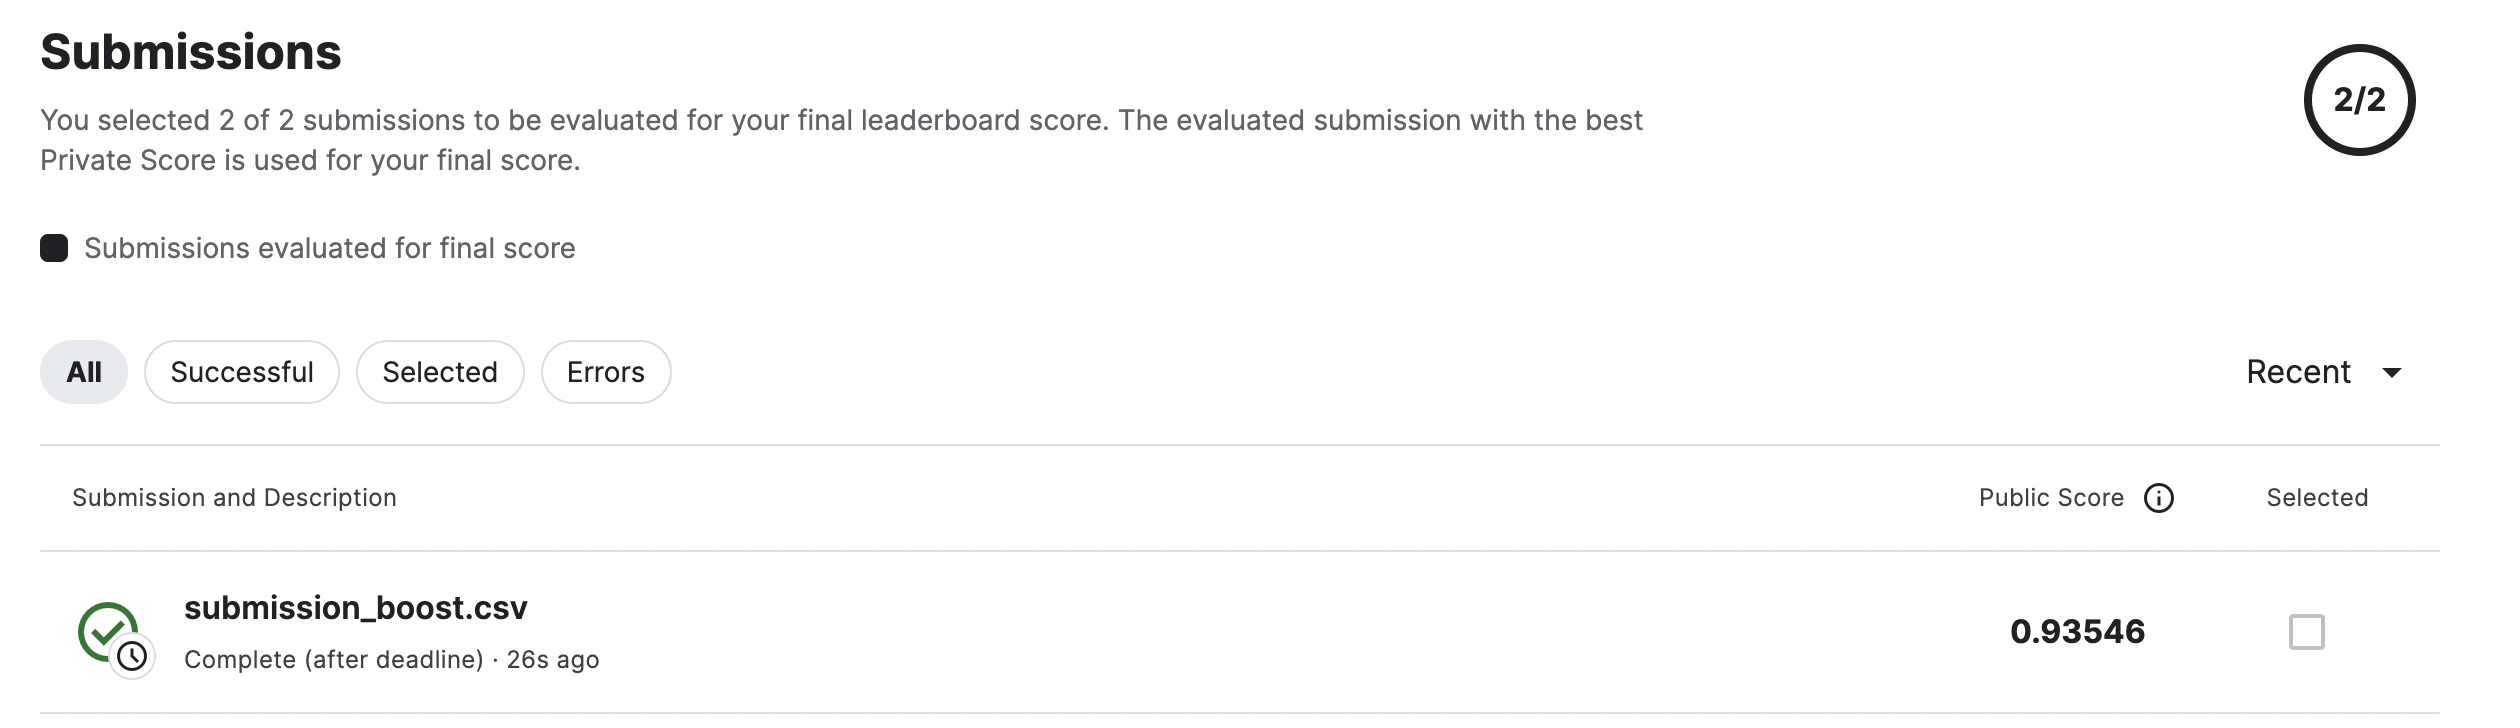